<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/datos/exams/Examen_Junio_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## SOLUCIÓN DEL EXAMEN DE JUNIO DE 2025

In [ ]:
# Instalamos la librería statsforecast
!pip install statsforecast
# https://nixtlaverse.nixtla.io/statsforecast/docs/models/autoarima.html
# Esto es para reiniciar el kernel y así poder importar luego la librería
import os
os.kill(os.getpid(), 9)

In [11]:
#IMPORTAMOS LIBRERÍAS Y DATOS
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns
from statsforecast.models import AutoARIMA

# Esto hacerlo solo después de ejecutarlo una vez y saber de qué warnings se trata
import warnings
warnings.filterwarnings("ignore")

# Importamos datos de parados
df=pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/refs/heads/main/clases/datos/exams/Junio25_PARAD.xlsx.xlsx", index_col=0)
# Crear una columna con el periodo, para convertirla en datetime y en el index.
df['periodo']=df.index.str[:4]+"Q"+df.index.str[-1:]
df['periodo']=pd.to_datetime(df['periodo'])
df.set_index('periodo', inplace=True)

# Importamos datos de afiliados (variable X)
ss=pd.read_excel("https://github.com/otoperalias/Coyuntura/raw/refs/heads/main/clases/datos/exams/Junio25_SS.xlsx", index_col=0)
# Crear una columna con el periodo, para convertirla en datetime y en el index.
ss['periodo']=ss.index.astype(str).str[:4]+"-"+ss.index.astype(str).str[-2:]
ss['periodo']=pd.to_datetime(ss['periodo'])
ss.set_index('periodo', inplace=True)
# Pasar a trimestres (aunque para el 2 Tr de 2025 falta un mes)
ss.index=ss.index.to_period("M")
ss=ss.resample('Q',label="right").mean()
ss.index=ss.index.to_timestamp()

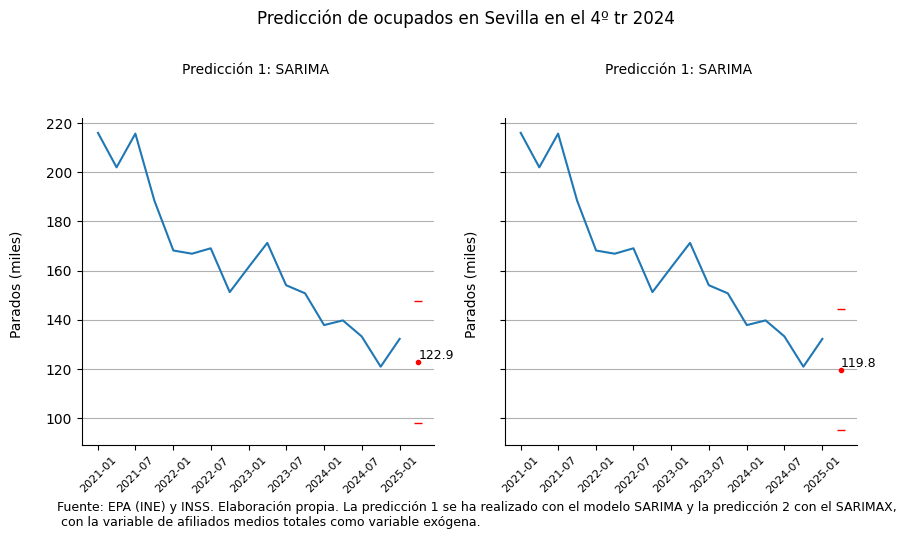

In [77]:
# INDICAMOS PROVINCIA Y FILTRAMOS
name=input("Introduce el nombre de la provincia: ")
prov=df.filter(like=name)
ss_prov=ss.filter(like=name).copy()

# 1. DESESTACIONALIZACIÓN

# Calculamos la serie desestacionalizada
stl_method = sm.tsa.STL(prov.iloc[:, 0], robust=True).fit()
ocup_aj=prov.iloc[:, 0]-stl_method.seasonal

# Evolución de los ocupados
fig,ax=plt.subplots(figsize=(6,4), dpi=100)
ax.plot(prov.loc["2021":], label="Datos brutos")
ax.plot(ocup_aj.loc["2021":],label="Desestacionalizados")
ax.set_ylabel("Parados (miles) \n")
ax.set_xlabel("")
ax.xaxis.set_tick_params(labelsize=9)
ax.set_title("Evolución de los parados en "+name+"\n")
ax.legend(frameon=False, fontsize=10)
ax.grid(axis='y', alpha=0.5)
ax.spines[['top','right']].set_visible(False)
fig.text(0.1,-0.03,"Fuente: EPA (INE). Serie desestacionalizada con el método STL. Elaboración propia.", size=9)
plt.show()
print(' \n \n ')

# 2. TASA DE VARIACIÓN
oc_tc=(ocup_aj/ocup_aj.shift(1)-1 )*100

# Tasa de variación
fig,ax=plt.subplots(figsize=(6,4), dpi=100)
ax.plot(oc_tc.loc["2021":])
ax.set_ylabel("Tasa de variación (%) \n")
ax.set_xlabel("")
ax.xaxis.set_tick_params(labelsize=9)
ax.set_title("Variación intertrimestral de los parados en "+name)
ax.grid(axis='y', alpha=0.5)
ax.spines[['top','right']].set_visible(False)
fig.text(0.1,-0.03,"Fuente: EPA (INE). Serie desestacionalizada con el método STL. Elaboración propia.", size=9)
plt.show()
print(' \n \n ')

# 3. PREDICCIÓN
# PREDICCIÓN MODELO SARIMA
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from statsforecast.arima import arima_string

data=prov.reset_index().copy()
data['unique_id']=name
data.columns=['ds','y','unique_id']
season_length = 4
horizon = 1 # number of predictions
models = [AutoARIMA(season_length=season_length)]
sf = StatsForecast(models=models, freq='QS')

prediction = sf.forecast(df=data, h=horizon, level=[95])
prediction=prediction.set_index(prediction.ds)

# PREDICCIÓN MODELO SARIMAX
exog=ss_prov.reset_index()
exog.columns=['ds','ss']
exog['unique_id']=name
data=data.merge(exog[['ds','ss']], on='ds',how="inner")
exog_out=exog[-1:]
prediction2 = sf.forecast(df=data, h=horizon, X_df=exog_out, level=[95])
prediction2=prediction2.set_index(prediction2.ds)

# Plot
fig,(ax1,ax2)=plt.subplots(1,2, sharey=True, figsize=(10,4.25), dpi=100)
  #SARIMA
ax1.plot(prov.loc["2021":], color="tab:blue")
ax1.plot(prediction['AutoARIMA'], color='r',marker='.')
ax1.plot(prediction['AutoARIMA-lo-95'] , color='r', marker='_')
ax1.plot(prediction['AutoARIMA-hi-95'] , color='r',marker='_')
ax1.set_title("Predicción 1: SARIMA \n", size=10, pad=20)
ax1.set_ylabel("Parados (miles) \n")
ax1.grid(axis='y')
ax1.xaxis.set_tick_params(labelsize=8, labelrotation=45)
ax1.spines[['top','right']].set_visible(False)
ax1.text(prediction.index[0],prediction['AutoARIMA'][0]*1.01,round(prediction['AutoARIMA'][0],1), fontsize=9)
  #SARIMAX
ax2.plot(prov.loc["2021":], color="tab:blue")
ax2.plot(prediction2['AutoARIMA'], color='r',marker='.')
ax2.plot(prediction2['AutoARIMA-lo-95'] , color='r', marker='_')
ax2.plot(prediction2['AutoARIMA-hi-95'] , color='r',marker='_')
ax2.set_title("Predicción 1: SARIMA \n", size=10, pad=20)
ax2.set_ylabel("Parados (miles) \n")
ax2.grid(axis='y')
ax2.xaxis.set_tick_params(labelsize=8, labelrotation=45)
ax2.spines[['top','right']].set_visible(False)
ax2.text(prediction2.index[0],prediction2['AutoARIMA'][0]*1.01,round(prediction2['AutoARIMA'][0],1), fontsize=9)
  # Notas
fig.text(0.3,1.1,"Predicción de ocupados en "+name+" en el 4º tr 2024", size=12)
fig.text(0.1,-0.08,"Fuente: EPA (INE) y INSS. Elaboración propia. La predicción 1 se ha realizado con el modelo SARIMA y la predicción 2 con el SARIMAX,\n \
con la variable de afiliados medios totales como variable exógena.", size=9)
plt.show()

